In [1]:
import os
import torch

from model.vgg import *
from ASNet.utils import *
from ASNet.ASModel import *
from ASNet.PCEModel import *
from ASNet.FineTuning import *
from ASNet.ASNet import *
from datasets.dataloader_cifar import *

import torch.utils.data as data
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [2]:
device = torch.device("cuda")

# VGG19

## Model

In [3]:
# !wget http://www.cs.unc.edu/~cyfu/cifar10/model_best.pth.tar

In [4]:
# tmp = torch.load('vgg19-dcbb9e9d.pth', torch.device('cuda:0'))

In [5]:
tmp = torch.load('model_best.pth.tar', torch.device('cuda:0'))

In [6]:
state_dict = {''.join(k.split('.module')) : v for k,v in tmp['state_dict'].items()}

In [7]:
state_dict.keys()

dict_keys(['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'features.14.weight', 'features.14.bias', 'features.16.weight', 'features.16.bias', 'features.19.weight', 'features.19.bias', 'features.21.weight', 'features.21.bias', 'features.23.weight', 'features.23.bias', 'features.25.weight', 'features.25.bias', 'features.28.weight', 'features.28.bias', 'features.30.weight', 'features.30.bias', 'features.32.weight', 'features.32.bias', 'features.34.weight', 'features.34.bias', 'classifier.1.weight', 'classifier.1.bias', 'classifier.4.weight', 'classifier.4.bias', 'classifier.6.weight', 'classifier.6.bias'])

In [8]:
model = vgg19(num_classes=10)

In [9]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [10]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [11]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

## CIFAR10 Dataset

In [12]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
]) 

In [13]:
# loading dataset
datasets.CIFAR10(root='/home/cherniavskii/ASNet/datasets/CIFAR10', train=True, download=True)

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /home/cherniavskii/ASNet/datasets/CIFAR10
    Split: Train

In [14]:
bs = 300 # batch_size
train_loader = trainloader_cifar_vgg19(bs, data_path='/home/cherniavskii/ASNet/datasets/')
test_loader = testloader_cifar_vgg19(bs, data_path='/home/cherniavskii/ASNet/datasets/')
train_labels = torch.tensor(train_loader.dataset.targets)

Train dataset loaded
Test dataset loaded


## Test the model

In [15]:
nAS = 50
r_max = 200 # maximum r
train_max_batch = len(train_loader)

In [16]:
compute_loss(model, device, test_loader)

 Top 1:  Accuracy: 9206.0/10000 (92.06%)


tensor(92.0600)

## ASNet

In [17]:
seq_model = get_seq_model(model)
possible_cut_idx = PossibleCutIdx(seq_model)

In [19]:
AS_models, Sigma = get_ASModel_FD(seq_model, train_loader, 
           possible_cut_idx[3:9], train_max_batch, r_max, device)

Finished Building AS model for layer: 18
Finished Building AS model for layer: 15
Finished Building AS model for layer: 13
Finished Building AS model for layer: 11
Finished Building AS model for layer: 9
Finished Building AS model for layer: 6


In [20]:
# fAS_name = './results/CIFAR10_VGG19_bn_ASModel_nAS_%d.pth'%(nAS)
# if os.path.isfile(fAS_name):
#     AS_models, Sigma = torch.load(fAS_name,map_location=device)
#     print('    AS layer loaded')
# else:
#     AS_models, Sigma = get_ASModel_FD(seq_model, train_loader, 
#            possible_cut_idx[5:8], train_max_batch,r_max,device)
#     torch.save([AS_models, Sigma], fAS_name) 
#     print('    AS layer computed')

In [21]:
possible_cut_idx

[0, 2, 5, 7, 10, 12, 14, 16, 19, 21, 23, 25, 28, 30, 32, 34, 39, 42, 44]

In [39]:
compression_rates = []
pre_test_accuracy = []
post_test_accuracy = []

In [41]:
for cut_idx in range(3,9):
    cut_idx_seq = possible_cut_idx[cut_idx] # This layer belongs to post-model
    print(f'----------\nCUT_Idx:{cut_idx_seq}')
    pre_model = seq_model[:cut_idx_seq]
    post_model = seq_model[cut_idx_seq:] 

    AS_model = AS_models[cut_idx_seq-1]
    AS_model.change_r(nAS)
    Z_train, y_train = compute_Z_AS_space(AS_model, pre_model, post_model,
                                          train_loader, train_max_batch, device=device)
    print('Z_train, Z_test generated')
    mean = torch.mean(Z_train, 0).to(device)
    var =  torch.std(Z_train, 0).to(device)
    PCE_model = PCEModel(mean, var)

    coeff, training_score_LR, training_score_labels = PCE_model.Training(\
              Z_train.to(device), y_train.to(device), train_labels[:Z_train.shape[0]].to(device))
    PCE_coeff = torch.tensor(coeff,dtype=torch.float32).to(device)
    print('Training score =', training_score_LR)

    basis_layer = BasisLayer(PCE_model, device)
    ASNet = ASNET(pre_model, AS_model, basis_layer, PCE_coeff).to(device)
    print('Training and testing error for ASNet without re-training')
    
     # Compression rate is a ratio of non-zero params in compressed models to original model
    compression_rates.append(100*(1.0-Total_param_sparse(ASNet)/Total_param_sparse(model)))
    print(f"Compression rate: {compression_rates[-1]:.3f}%")
    
    optimizer = torch.optim.Adam([{'params': ASNet.premodel.parameters(), 
                                   'lr': 1e-4},
                                {'params': ASNet.AS.parameters(), 'lr': 1e-5},
                                {'params': ASNet.PCE.parameters(), 'lr': 1e-5}])
 
     
    epochs = 20
    #retrain model
    pre_test_accuracy.append(compute_loss(ASNet, device, test_loader))
    print(f"Pretrained accuracy: {pre_test_accuracy[-1]:.3f}")
    print('ASNet trained {} epoches is loaded'.format(epochs))
    print(f"Trained accuracy: {train(ASNet, device, train_loader, optimizer, epoch=epochs)}")
    post_test_accuracy.append(compute_loss(ASNet, device, test_loader))
    print(f"Test accuracy: {post_test_accuracy[-1]:.3f}")

----------
CUT_Idx:7
Z_train, Z_test generated


/home/cherniavskii/.local/lib/python3.6/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


Training score = 0.5625295895475182
Training and testing error for ASNet without re-training
Compression rate: 91.415%
 Top 1:  Accuracy: 7063.0/10000 (70.63%)
Pretrained accuracy: 70.630
ASNet trained 20 epoches is loaded
Trained accuracy: 69.178
 Top 1:  Accuracy: 7329.0/10000 (73.29%)
Test accuracy: 73.290
----------
CUT_Idx:10
Z_train, Z_test generated


/home/cherniavskii/.local/lib/python3.6/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


Training score = 0.7164048909001829
Training and testing error for ASNet without re-training
Compression rate: 96.678%
 Top 1:  Accuracy: 8300.0/10000 (83.00%)
Pretrained accuracy: 83.000
ASNet trained 20 epoches is loaded
Trained accuracy: 82.718
 Top 1:  Accuracy: 8411.0/10000 (84.11%)
Test accuracy: 84.110
----------
CUT_Idx:12
Z_train, Z_test generated


/home/cherniavskii/.local/lib/python3.6/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


Training score = 0.7903868148947072
Training and testing error for ASNet without re-training
Compression rate: 93.249%
 Top 1:  Accuracy: 8721.0/10000 (87.21%)
Pretrained accuracy: 87.210
ASNet trained 20 epoches is loaded
Trained accuracy: 90.938
 Top 1:  Accuracy: 8805.0/10000 (88.05%)
Test accuracy: 88.050
----------
CUT_Idx:14
Z_train, Z_test generated


/home/cherniavskii/.local/lib/python3.6/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


Training score = 0.8577141639459381
Training and testing error for ASNet without re-training
Compression rate: 90.379%
 Top 1:  Accuracy: 9009.0/10000 (90.09%)
Pretrained accuracy: 90.090
ASNet trained 20 epoches is loaded
Trained accuracy: 97.88
 Top 1:  Accuracy: 9062.0/10000 (90.62%)
Test accuracy: 90.620
----------
CUT_Idx:16
Z_train, Z_test generated


/home/cherniavskii/.local/lib/python3.6/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


Training score = 0.9007291194103597
Training and testing error for ASNet without re-training
Compression rate: 87.508%
 Top 1:  Accuracy: 9143.0/10000 (91.43%)
Pretrained accuracy: 91.430
ASNet trained 20 epoches is loaded
Trained accuracy: 99.382
 Top 1:  Accuracy: 9121.0/10000 (91.21%)
Test accuracy: 91.210
----------
CUT_Idx:19
Z_train, Z_test generated


/home/cherniavskii/.local/lib/python3.6/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


Training score = 0.9391395121412234
Training and testing error for ASNet without re-training
Compression rate: 87.628%
 Top 1:  Accuracy: 9205.0/10000 (92.05%)
Pretrained accuracy: 92.050
ASNet trained 20 epoches is loaded
Trained accuracy: 99.684
 Top 1:  Accuracy: 9089.0/10000 (90.89%)
Test accuracy: 90.890


In [44]:
!pip3 install matplotlib

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 11.6 MB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 40.7 MB/s eta 0:00:01
You should consider upgrading via the '/cephfs/local/python/3.6.9/bin/python3.6 -m pip install --upgrade pip' command.


In [45]:
import matplotlib.pyplot as plt

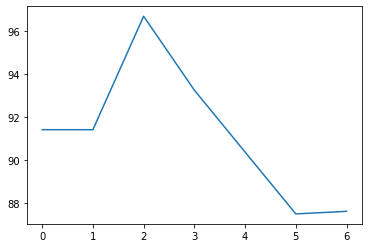

In [46]:
plt.plot(compression_rates)

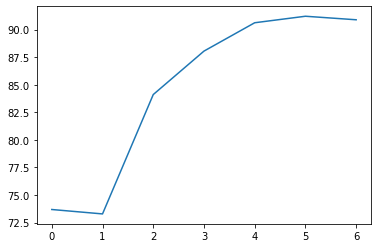

In [47]:
plt.plot(post_test_accuracy)

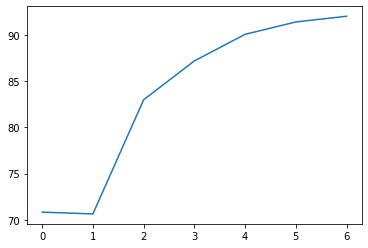

In [48]:
plt.plot(pre_test_accuracy)

In [51]:
max(pre_test_accuracy)

tensor(92.0500)